# Prompt 3

In [1]:
import io
import os
import requests
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
infile = '../../Data/circuit_criminal_2019_withDescriptions.csv'
spark = SparkSession \
    .builder \
    .appName("Criminal Expungement") \
    .getOrCreate()
circuit = spark.read.csv(infile, inferSchema=True, header = True)
circuit.printSchema()

# data wrangling
circuit=circuit\
            .fillna('Unknown',subset='Race')\
            .replace('Other (Includes Not Applicable, Unknown)','Unknown',subset='Race')

# census data 
population = spark.read.csv('../../Data/2019 Virginia Population.csv',header=True)
population = population.drop('Fact Note', 'Value Note for Virginia')
pop_2019 = 8535519
pop_white = 61.2
pop_black = 19.9
pop_hispanic = 9.8
pop_native_amer = 0.5
pop_asian_pacific = 7.0
pop_two_or_more = 3.2 # problem: doesn't exist
# problem: unknown populations are not represented in 

pop = spark.createDataFrame(
    [('White', round(pop_2019*(pop_white/100),2)),  # create your data here, be consistent in the types.
     ('Black', round(pop_2019*(pop_black/100),2)),
     ('Hispanic', round(pop_2019*(pop_hispanic/100),2)),
     ('American Indian Or Alaskan Native', round(pop_2019*(pop_native_amer/100),2)),
     ('Asian Or Pacific Islander', round(pop_2019*(pop_asian_pacific/100),2)),
     ('Two or More Races', round(pop_2019*(pop_two_or_more/100),2)),],
    ["Race", "Population_2019"]  # add your column names here
)
pop.show(truncate=False)
pop.createOrReplaceTempView('pop')

root
 |-- CodeSection_Description: string (nullable = true)
 |-- CodeSection: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- HearingDate: timestamp (nullable = true)
 |-- HearingResult: string (nullable = true)
 |-- HearingJury: string (nullable = true)
 |-- HearingPlea: string (nullable = true)
 |-- HearingType: string (nullable = true)
 |-- HearingRoom: string (nullable = true)
 |-- fips: integer (nullable = true)
 |-- Filed: timestamp (nullable = true)
 |-- Commencedby: string (nullable = true)
 |-- Locality: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Charge: string (nullable = true)
 |-- ChargeType: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- OffenseDate: timestamp (nullable = true)
 |-- ArrestDate: timestamp (nullable = true)
 |-- DispositionCode: string (nullable = true)
 |-- DispositionDate: timestamp (nullable = true)
 |-- ConcludedBy: str

In [25]:
circuit.createOrReplaceTempView('df')
code = '18.2-250.1, POSSESSION OF MARIJUANA'
df_strat = spark.sql(
'''
SELECT code_and_desc,ChargeType,Race,Count(Race) as `# Charges`
FROM DF t1
GROUP BY code_and_desc,ChargeType,Race
'''
)
df_strat = df_strat.join(pop,how='inner',on="Race")
df_strat = df_strat.withColumn('# Charges/100K',df_strat['# Charges']*(100000)/df_strat['Population_2019'])
df_strat.select(['code_and_desc','Race','ChargeType','# Charges/100K']).toPandas().rename({
    'code_and_desc': 'Code and Most Frequent Description'
},axis=1)

,Code and Most Frequent Description,Race,ChargeType,# Charges/100K
0,"18.2-416, ABUSIVE LANGUAGE TO ANOTHER",White,Misdemeanor,0.057430
1,"18.2-152.5:1, USE COMPUTER GATHR ID INFO",White,Felony,0.153147
2,"18.2-362, BIGAMY",White,Felony,0.019143
3,"18.2-79, ATTEMPT ARSON",White,Felony,0.038287
4,"19.2-152.8, VIOLATION OF PROTECTIVE ORDR",White,Misdemeanor,0.038287
...,...,...,...,...
1497,"18.2-111, EMBEZZLEMENT",Asian Or Pacific Islander,Felony,0.669471
1498,"18.2-386.1, FILM NONCONSENTED NUDE MINOR",Asian Or Pacific Islander,Felony,0.167368
1499,"18.2-67.5:1, INDECENT EXPOSURE",Asian Or Pacific Islander,Felony,0.167368
1500,"18.2-456, FAIL TO APPEAR; CONTEMPT",Asian Or Pacific Islander,Misdemeanor,0.334736


In [19]:
from pyspark.sql.functions import max as maximum_value
from pyspark.sql.functions import min as minimum_value
df_strat.groupBy('code_and_desc','ChargeType').agg(maximum_value('# Charges/100K'),minimum_value('# Charges/100K')).show()

+--------------------+-----------+--------------------+--------------------+
|       code_and_desc| ChargeType| max(# Charges/100K)| min(# Charges/100K)|
+--------------------+-----------+--------------------+--------------------+
|18.2-60.4, VIOLAT...|Misdemeanor|  1.5307009029981415| 0.23909692326970877|
|18.2-22/18.2-51, ...|     Felony|0.019143381058362996|0.019143381058362996|
|29.1-553, SELL WI...|     Felony| 0.16736784588862477|0.019143381058362996|
|8-104, OPERATE MA...|Misdemeanor| 0.16736784588862477| 0.16736784588862477|
|19.2-305, EARLY T...|Misdemeanor|  28.117794815078636| 0.17229042952526696|
|19.2-100, EXTRADI...|     Felony|0.019143381058362996|0.019143381058362996|
|18.2-419, PICKETI...|Misdemeanor|0.019143381058362996|0.019143381058362996|
|18.2-435, PERJURY...|     Felony| 0.21057719164199296| 0.05887311165377467|
|46.2-1156, FAIL T...| Infraction| 0.05887311165377467| 0.05887311165377467|
|18.2-195, CREDIT ...|Misdemeanor|  3.2380211409576067|  0.8614521476263348|

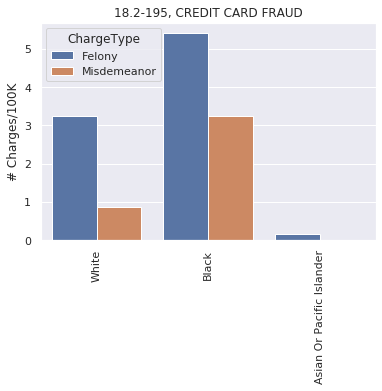

In [4]:
# code
sns.set()
code = '18.2-195, CREDIT CARD FRAUD'
data = df_strat[df_strat['code_and_desc'] == code].toPandas()
sns.barplot(data=data,x='Race',y='# Charges/100K',hue='ChargeType')
plt.xticks(rotation=90);
plt.title(code)
plt.xlabel('');
plt.show()